In [2]:
"""
This is a the shrinkage version of Transport map. In this version, 
the regression functions $f_i$ and the niggest parameters $d_i$ are 
assumed to have some specific structures. These values are given by
the parametric covariance matrix. Unlike the example in other notebook,
here we try to estimate the parametric covariance matrix parameters 
using the integrated log-likelihood function.


Author: Anirban Chakraborty,
Last modified: May 13, 2024
"""
%load_ext autoreload
%autoreload 2

### Load necessary libraries

In [3]:
import torch
import numpy as np
from veccs import orderings
from gpytorch.kernels import MaternKernel
from sklearn.gaussian_process import kernels
from matplotlib import pyplot as plt

from batram.helpers import make_grid, GaussianProcessGenerator
from batram.legmods import Data, SimpleTM
from batram.shrinkmods import ShrinkTM, EstimableShrinkTM, EstimableShrinkTMRefactor


/home/anirban0451/miniconda3/envs/climate/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Comparing log-score with the base transport maps (exponential kernel)

In [3]:
torch.manual_seed(20240507)

In [4]:
experiments_v1_data = torch.load("../results/initial_experiments_truth_v1.pt")
experiments_v2_data = torch.load("../results/initial_experiments_truth_v2.pt")

In [5]:
## kernel and location parameters

num_locs = 30; dim_locs = 2
nu_original = 0.5
length_scale_original = 0.3
numSamples = 30
sd_noise=1e-6
largest_conditioning_set = 30

In [6]:
## generate data

locs = make_grid(num_locs, dim_locs)

#sample data
gpkernel = kernels.Matern(nu=nu_original, length_scale=length_scale_original)
gp = GaussianProcessGenerator(locs=locs, kernel=gpkernel, sd_noise=sd_noise)
numpydata = gp.sample(num_reps=200)

In [7]:
## ordering the locations

locsorder = orderings.maxmin_cpp(locs=locs) #find maxmin-ordeing
locs = locs[locsorder, ...]
nn = orderings.find_nns_l2(locs, largest_conditioning_set)

In [8]:
## getting the data ready

torchdata = torch.from_numpy(numpydata).float() #converts into torch format
torchdata = torchdata[:, locsorder]
numSamples = [2, 3, 5, 10, 15, 20]
neglogScore_tm = torch.zeros(len(numSamples))
neglogScore_shrink = torch.zeros(len(numSamples))
tm_models = []
shrink_models = []
yreps = 50 #to be used for estimating log-score
nsteps = 1500

In [9]:
## fit models
for i, n in enumerate(numSamples):
    obs = torchdata[0:n, :] #snip first n samples
    #if obs.dim() == 1:
    #    obs = obs.unsqueeze(0)
    obsTrain = obs

    # Create a `Data` object for use with the `SimpleTM`/ `ShrinkTM` model.
    data = Data.new(torch.as_tensor(locs).float(), obs, torch.as_tensor(nn))

    tm = SimpleTM(data, theta_init=None, linear=False, smooth=1.5, nug_mult=4.0)
    opt = torch.optim.Adam(tm.parameters(), lr=0.01)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, nsteps)
    res = tm.fit(
        nsteps, 0.1, test_data=tm.data, optimizer=opt, scheduler=sched, batch_size=300
    )
    tm_models.append(tm)
    
    shrink_tm = EstimableShrinkTM(data=data, linear=False, 
                     transportmap_smooth=1.5, 
                     parametric_kernel= "exponential",
                     param_nu=0.5,
                     param_ls=1.0)
    opt2 = torch.optim.Adam(shrink_tm.parameters(), lr=0.01)
    sched2 = torch.optim.lr_scheduler.CosineAnnealingLR(opt2, nsteps)
    res2 = shrink_tm.fit(
        nsteps, 0.1, test_data=shrink_tm.data, optimizer=opt2, scheduler=sched2, batch_size=300,

    )
    shrink_models.append(shrink_tm)

    for _j in range(0, 50):
        with torch.no_grad():
            neglogScore_tm[i] += tm.score(torchdata[(100 + _j), :])
        neglogScore_shrink[i] += shrink_tm.score(torchdata[(100 + _j), :])
    

Train Loss: -9287.448, Test Loss: -9287.448: 100%|██████████| 1500/1500 [21:49<00:00,  1.15it/s]


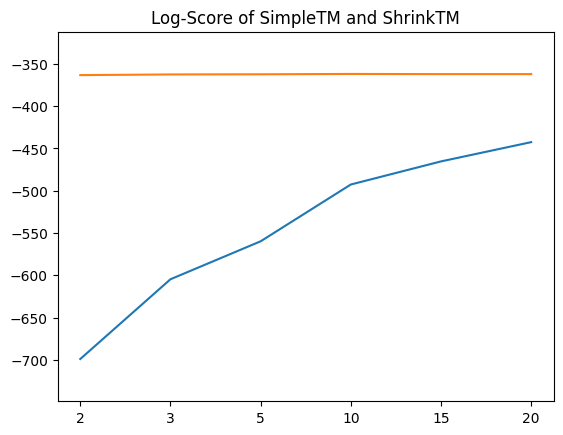

In [10]:
logScore_tm = neglogScore_tm/50
logScore_shrink = neglogScore_shrink/50
plt.plot(torch.arange(len(numSamples)), logScore_tm)
plt.plot(torch.arange(len(numSamples)), logScore_shrink)
plt.ylim(torch.concatenate((logScore_tm, logScore_shrink)).min() - 50, 
         torch.concatenate((logScore_tm, logScore_shrink)).max() + 50)
plt.title("Log-Score of SimpleTM and ShrinkTM")
plt.xticks(torch.arange(len(numSamples)), labels = numSamples);

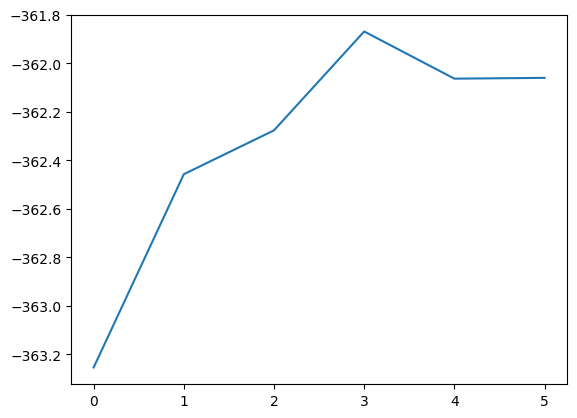

In [11]:
plt.plot(torch.arange(len(numSamples)), logScore_shrink)

In [12]:
torch.save({
    "tm_models": tm_models,
    "shrink_models": shrink_models,
    "tm_logscore" : logScore_tm,
    "shrink_logscore": logScore_shrink,
    "numSamples": numSamples
}, "../results/experiments_estimable_exponential.pt")

In [13]:
exponential = torch.load("../results/experiments_estimable_exponential.pt")
shrink_models = exponential["shrink_models"]

In [14]:
for i in range(len(shrink_models)):
    with torch.no_grad():
        print(shrink_models[i].parametric_kernel.log_ls.exp())

tensor([0.3179])
tensor([0.3051])
tensor([0.3036])
tensor([0.3110])
tensor([0.3052])
tensor([0.3064])


In [15]:
for i in range(len(shrink_models)):
    with torch.no_grad():
        print(1 - shrink_models[i].nugget_shrinkage_factor.exp().add(1).reciprocal())

tensor(0.0351)
tensor(0.0472)
tensor(0.0439)
tensor(0.0317)
tensor(0.0568)
tensor(0.0576)


### Comparing log-score with the base transport maps (matern kernel)

In [4]:
torch.manual_seed(20240507)

In [5]:
## kernel and location parameters

num_locs = 30; dim_locs = 2
nu_original = 1.5
length_scale_original = 0.7
numSamples = 30
sd_noise=1e-6
largest_conditioning_set = 30

In [6]:
## generate data

locs = make_grid(num_locs, dim_locs)

#sample data
gpkernel = kernels.Matern(nu=nu_original, length_scale=length_scale_original)
gp = GaussianProcessGenerator(locs=locs, kernel=gpkernel, sd_noise=sd_noise)
numpydata = gp.sample(num_reps=200)

In [7]:
## ordering the locations

locsorder = orderings.maxmin_cpp(locs=locs) #find maxmin-ordeing
locs = locs[locsorder, ...]
nn = orderings.find_nns_l2(locs, largest_conditioning_set)

In [8]:
## getting the data ready

torchdata = torch.from_numpy(numpydata).float() #converts into torch format
torchdata = torchdata[:, locsorder]
numSamples = [2, 3, 5, 10, 15, 20]
neglogScore_tm = torch.zeros(len(numSamples))
neglogScore_shrink = torch.zeros(len(numSamples))
tm_models = []
shrink_models = []
yreps = 50 #to be used for estimating log-score
nsteps = 1000

In [9]:
## fit models
for i, n in enumerate(numSamples):
    obs = torchdata[0:n, :] #snip first n samples
    #if obs.dim() == 1:
    #    obs = obs.unsqueeze(0)
    obsTrain = obs

    # Create a `Data` object for use with the `SimpleTM`/ `ShrinkTM` model.
    data_shrink = Data.new(torch.as_tensor(locs), obs, torch.as_tensor(nn))
    data_tm = Data.new(torch.as_tensor(locs).float(), obs, torch.as_tensor(nn))

    tm = SimpleTM(data_tm, theta_init=None, linear=False, smooth=1.5, nug_mult=4.0)
    opt = torch.optim.Adam(tm.parameters(), lr=0.01)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, nsteps)
    res = tm.fit(
        nsteps, 0.1, test_data=tm.data, optimizer=opt, scheduler=sched, batch_size=300
    )
    tm_models.append(tm)
    
    shrink_tm = EstimableShrinkTMRefactor(data=data_shrink, linear=False, 
                     transportmap_smooth=1.5, 
                     parametric_kernel= "matern",
                     param_nu=nu_original,
                     param_ls=1.0)
    opt2 = torch.optim.Adam(shrink_tm.parameters(), lr=0.01)
    sched2 = torch.optim.lr_scheduler.CosineAnnealingLR(opt2, nsteps)
    res2 = shrink_tm.fit(
        nsteps, 0.1, test_data=shrink_tm.data, optimizer=opt2, scheduler=sched2, batch_size=300,

    )
    shrink_models.append(shrink_tm)

    for _j in range(0, 50):
        with torch.no_grad():
            neglogScore_tm[i] += tm.score(torchdata[(100 + _j), :])
        neglogScore_shrink[i] += shrink_tm.score(torchdata[(100 + _j), :])

  0%|          | 0/1000 [00:00<?, ?it/s]

Train Loss: -5940.225, Test Loss: -5962.760: 100%|██████████| 1000/1000 [22:55<00:00,  1.38s/it]


ValueError: Expected value argument (Tensor of shape ()) to be within the support (Real()) of the distribution StudentT(df: 6.125, loc: 0.0, scale: 1.0), but found invalid values:
nan

In [13]:
for _j in range(0, 50):
    with torch.no_grad():
        neglogScore_tm[i] += tm.score(torchdata[(100 + _j), :])

ValueError: Expected value argument (Tensor of shape ()) to be within the support (Real()) of the distribution StudentT(df: 6.125, loc: 0.0, scale: 1.0), but found invalid values:
nan

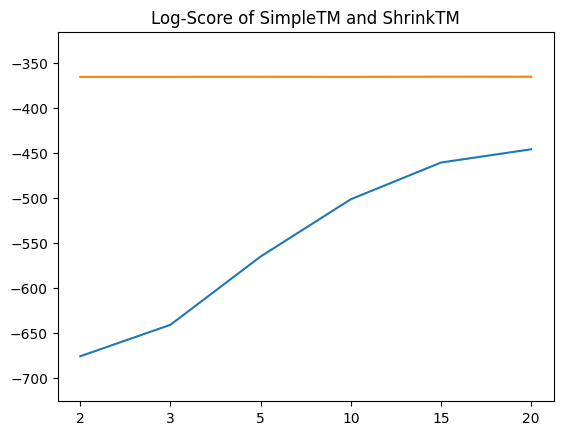

In [ ]:
logScore_tm = neglogScore_tm/50
logScore_shrink = neglogScore_shrink/50
plt.plot(torch.arange(len(numSamples)), logScore_tm)
plt.plot(torch.arange(len(numSamples)), logScore_shrink)
plt.ylim(torch.concatenate((logScore_tm, logScore_shrink)).min() - 50, 
         torch.concatenate((logScore_tm, logScore_shrink)).max() + 50)
plt.title("Log-Score of SimpleTM and ShrinkTM")
plt.xticks(torch.arange(len(numSamples)), labels = numSamples);

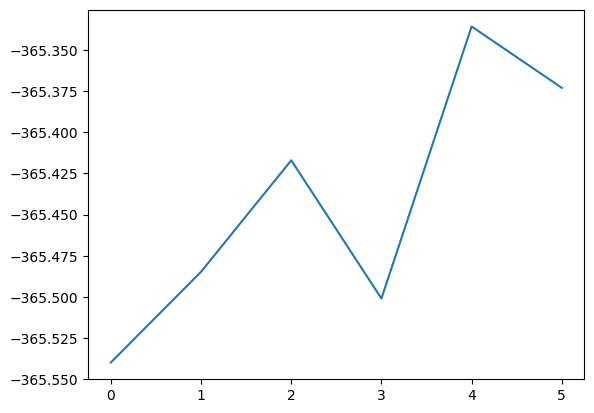

In [ ]:
plt.plot(torch.arange(len(numSamples)), logScore_shrink)

In [ ]:
torch.save({
    "tm_models": tm_models,
    "shrink_models": shrink_models,
    "tm_logscore" : logScore_tm,
    "shrink_logscore": logScore_shrink,
    "numSamples": numSamples
}, "../results/experiments_estimable_matern15.pt")

In [ ]:
for i in range(len(shrink_models)):
    with torch.no_grad():
        print(shrink_models[i].parametric_kernel.log_ls.exp())

tensor([1.0002])
tensor([1.0000])
tensor([1.0001])


In [ ]:
for i in range(len(shrink_models)):
    with torch.no_grad():
        print(1 - shrink_models[i].nugget_shrinkage_factor.exp().add(1).reciprocal())

tensor(0.4755)
tensor(0.6489)
tensor(0.7291)
